# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf

# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Reading Data

In [2]:
# csv file
df = pd.read_csv('../input/scrapped-lyrics-from-6-genres/lyrics-data.csv')

# As the model takes a lot of time to train using the whole dataset
# We will instead use only a small portion of it.
# Training on English songs only
df.drop(['ALink','SName','SLink'],axis=1,inplace=True)
df = df[df['Idiom']=='ENGLISH']
df = df[:800]
df.shape

(800, 2)

# Data Preprocessing

In [3]:
# Tokenization
tokenizer = Tokenizer()
# Used to preprocess the text, by removing the comma and
# other punctuations for example. We also removed numbers
# It also splits the sentences to words, and turns all words
# into lower case

tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())
# Applying the tokenizer

total_words = len(tokenizer.word_index)+1
# We add one to the index, as index starts from zero

tokenized_sentences = tokenizer.texts_to_sequences(df['Lyric'].astype(str))
# Turns the words into integer type by classifying them according to word dictionary.
#tokenized_sentences[0]
# Checking the first element, to understand what happened

In [4]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
# Having reached this point, input_sequences contains array of lists of words, starting from
# a list containg 2 words, then we append a third word to them, then another word, and so on.
# This causes a problem, as the length of the lists are not equal, so we pad them by adding zeros
# at the beginnig, till they are all of the same length (the maximum length)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences]) 
# Gets the length of the longest list in the 
# array of lists
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [5]:
# Dividing the data into X, y -----> the training set, and the labels to be predicted
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
# Takes all elemnts in each row, except the last element, and places them in X
# while labels takes the last element (the element which we should predict)

y = tf.keras.utils.to_categorical(labels, num_classes=total_words) # One hot encoding
# number of classes is now equal to the number of unique words in the song lyrics

# Model

In [6]:
# creating model
model = Sequential()

2022-01-10 17:42:44.293347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 17:42:44.381919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 17:42:44.382783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 17:42:44.384565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
#model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
# dimension of input: total_words, the number of unique words we have
# 40: the desired dimension of the output
# input_length: the sequence length is all the words except the last one (the one
# we will predict)
model.add(Bidirectional(LSTM(250))) # 250 is the average number of words in a song
# So our cycle is the average length of a song
# We used LSTM instead of simple RNN as simple RNN faces a vanishing gradient
# problem, also, we need to remember the previous words, to predict the next words.

model.add(Dropout(0.1)) # To overcome overfitting
model.add(Dense(total_words, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 655, 40)           362040    
_________________________________________________________________
bidirectional (Bidirectional (None, 500)               582000    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 9051)              4534551   
Total params: 5,478,591
Trainable params: 5,478,591
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, batch_size=32, epochs=30,callbacks=[earlystop], validation_split = 0.3)

2022-01-10 17:42:47.517385: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4982104848 exceeds 10% of free system memory.
2022-01-10 17:42:53.381856: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4982104848 exceeds 10% of free system memory.
2022-01-10 17:42:57.016402: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-01-10 17:43:00.074843: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4301/4301 [==============================] - ETA: 0s - loss: 6.0677 - accuracy: 0.0681

2022-01-10 17:51:19.801572: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2135203308 exceeds 10% of free system memory.
2022-01-10 17:51:22.326349: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2135203308 exceeds 10% of free system memory.


4301/4301 [==============================] - 579s 134ms/step - loss: 6.0677 - accuracy: 0.0681 - val_loss: 6.1098 - val_accuracy: 0.0755
Epoch 2/30
4301/4301 [==============================] - 567s 132ms/step - loss: 5.2133 - accuracy: 0.1325 - val_loss: 6.1515 - val_accuracy: 0.0906
Epoch 3/30
4301/4301 [==============================] - 567s 132ms/step - loss: 4.5042 - accuracy: 0.2038 - val_loss: 6.3351 - val_accuracy: 0.0875
Epoch 4/30
4301/4301 [==============================] - 568s 132ms/step - loss: 3.9127 - accuracy: 0.2763 - val_loss: 6.4592 - val_accuracy: 0.0869
Epoch 5/30
4301/4301 [==============================] - 568s 132ms/step - loss: 3.4391 - accuracy: 0.3404 - val_loss: 6.6481 - val_accuracy: 0.0845
Epoch 6/30
4301/4301 [==============================] - 569s 132ms/step - loss: 3.0615 - accuracy: 0.3955 - val_loss: 6.7616 - val_accuracy: 0.0835
Epoch 7/30
4301/4301 [==============================] - 570s 133ms/step - loss: 2.7614 - accuracy: 0.4415 - val_loss: 6.937

# Save The Model

In [10]:
# save model before continuing the code, in case we run out of memory
from tensorflow.keras.models import load_model
model.save('song_lyrics_generator_Not_One.h5')

# Plot losses

<AxesSubplot:>

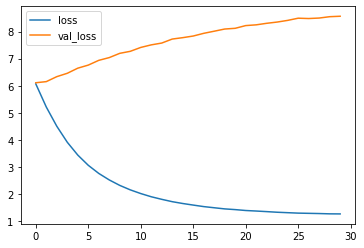

In [11]:
df = pd.DataFrame(history.history)
df[['loss','val_loss']].plot()

# Generating Song Lyrics

In [12]:
# el input_text dh el text elly badeehlo, w bykamel 3leh el o8nya
# next_words dyh 3adad el kalemat el hy3mlha prediction
def complete_this_song(input_text, next_words):
    for _ in range(next_words):
        # for _ in... this is like a place holder, which upholds the syntax.
        # We use it when we don't want to use the variable, so we leave it empty.
        
        # Doing the same things to the input as we did when training the model
        token_list = tokenizer.texts_to_sequences([input_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        #predicted = model.predict_classes(token_list, verbose=0)
        predicted = np.argmax(model.predict(token_list), axis=-1)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                # Gets the word corresponding the the value predicted
                # [Converting from numeric to string again]
                output_word = word
                break
        input_text += " " + output_word
    return input_text


In [13]:
#complete_this_song("i must tell you about", 40)

In [14]:
complete_this_song("Never have i ever", 155)

"Never have i ever know what you do not what i need anymore i don't care why are you say i would fade down but i know you dig up but baby i can't understand another day why can't you leave me just already so reason to take myself free but i won't believe you can cause yourself you won't you say no but you don't know who i am not this will you hide my time no don't you know no oh no you say i don't have to go home i won't stay no no day don't you tread now don't be no will be every time around to be i'll be so long i'll be my friend this life i have to go i'll take a love out i have all that i would feel the pain but i feel all these fears that i am not there until the night you did but i know"

In [15]:
complete_this_song("This is the beginning", 155)

"This is the beginning of my life of me and my face and i will not be the one you ever fall but i won't ever let you down you stumbled down and you won't you be a part of me a part of me you know when you're not here with you you got to call it in this world in my head in my head in the clouds a can’t ending believe the world you breathe when we know we fear this is the time we live in this you can see a dying a pretty time you say they know you're gonna take you you never hear this time you're a thousand dream of my cloth you said you take me you take me crazy but i dont dont know no one day i didn't wanna waste my last time we lost waiting so i say no no you don't want no more you never did"

In [16]:
complete_this_song("if i could", 12)

'if i could have to the hell this is the friend you bring me to'

In [17]:
complete_this_song("i must tell you about", 40)

"i must tell you about my face you see me my heaven friend i am not on a dream but you're just a minute that i believe you try to understand you're scared to change who i saw you so you make me feel like"